In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

In [2]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, 784).astype(np.float32)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)
train_data, test_data, train_target, test_target = torch.from_numpy(train_data), torch.from_numpy(test_data), torch.from_numpy(train_target), torch.from_numpy(test_target)

In [3]:
EPOCHS=50
BATCH_SIZE=128
ACTIVATIONS = [torch.nn.Sigmoid, torch.nn.Tanh, torch.nn.ReLU]
LAYERS = [1,2,3,4,5,6,7]

lossFn = torch.nn.CrossEntropyLoss()

results_accumulator = []

In [4]:
def flat_map(lists):
    result = []
    for x in lists:
        result.extend(x)
    return result

In [19]:
for activation_fn in ACTIVATIONS:
    for num_of_layers in LAYERS:
        layers = [torch.nn.Linear(784 if i == 0 else 100, 100) for i in range(num_of_layers)]
        model = torch.nn.Sequential(*[
            *flat_map([[layer, activation_fn()] for layer in layers]),
            torch.nn.Linear(100, 10),
            torch.nn.Softmax(dim=1)
        ])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        result_accumulator_item = {
            "fn": activation_fn.__name__,
            "layers": num_of_layers,
            "losses": [],
            "gradients": [],
        }
        
        for epoch in progressbar(range(EPOCHS)):
            order = torch.from_numpy(np.random.permutation(train_data.shape[0]))
            train_x = train_data[order]
            train_y = train_target[order]
            loss_agg = 0
            gradients = [torch.zeros_like(layer.weight) for layer in layers]
        
            for i in range(0, train_x.shape[0] // BATCH_SIZE):
                batch_x = train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
                batch_y = train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
                optimizer.zero_grad()
                output = model(batch_x)
                loss = lossFn(output, batch_y)
                loss.backward()
                optimizer.step()
                
                loss_agg += loss.item()
                for i in range(num_of_layers):
                    gradients[i] += layers[i].weight.grad
            
            gradient_sizes = [gradient.norm() for gradient in gradients]
            result_accumulator_item["losses"].append(loss_agg)
            result_accumulator_item["gradients"].append(gradient_sizes)
            
        results_accumulator.append(result_accumulator_item)


100% (50 of 50) |########################| Elapsed Time: 0:01:01 Time:  0:01:010106
100% (50 of 50) |########################| Elapsed Time: 0:01:14 Time:  0:01:140107
100% (50 of 50) |########################| Elapsed Time: 0:01:30 Time:  0:01:300109
100% (50 of 50) |########################| Elapsed Time: 0:01:45 Time:  0:01:450210
100% (50 of 50) |########################| Elapsed Time: 0:02:01 Time:  0:02:010212
100% (50 of 50) |########################| Elapsed Time: 0:02:18 Time:  0:02:180213
100% (50 of 50) |########################| Elapsed Time: 0:02:33 Time:  0:02:330315
100% (50 of 50) |########################| Elapsed Time: 0:00:54 Time:  0:00:540105
100% (50 of 50) |########################| Elapsed Time: 0:01:08 Time:  0:01:080106
100% (50 of 50) |########################| Elapsed Time: 0:01:23 Time:  0:01:230108
100% (50 of 50) |########################| Elapsed Time: 0:01:36 Time:  0:01:360109
100% (50 of 50) |########################| Elapsed Time: 0:01:49 Time:  0:01

In [20]:
with open("results.pkl", "wb") as f:
    pickle.dump(results_accumulator, f)

In [5]:
with open("results.pkl", "rb") as f:
    results_accumulator = pickle.load(f)

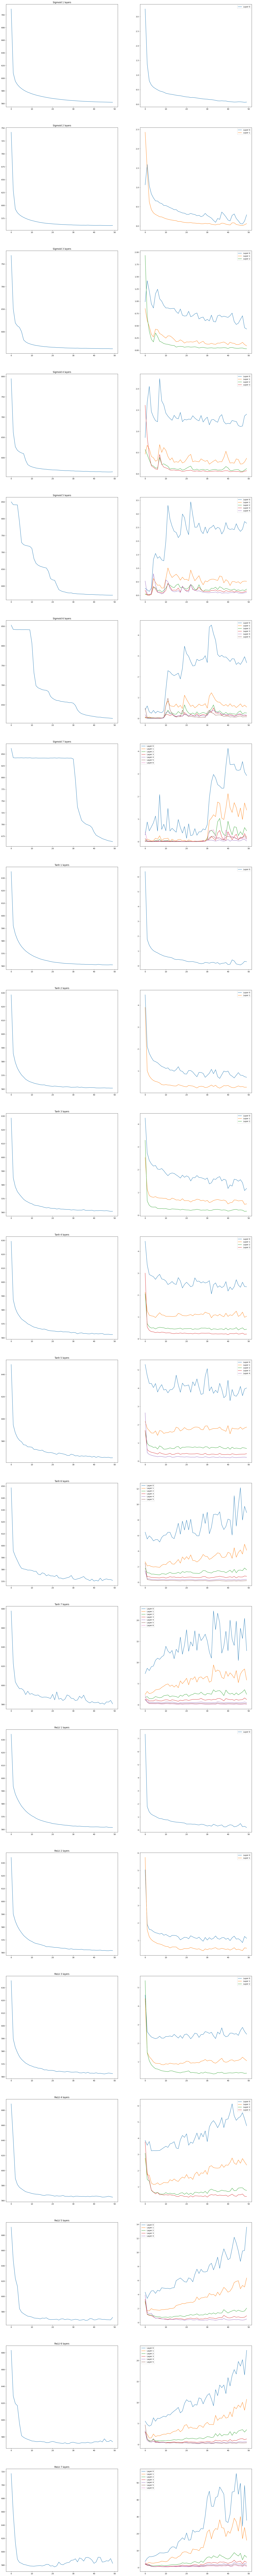

In [21]:
fig = plt.figure(figsize=(24, 12*len(results_accumulator)))
axes = fig.subplots(len(results_accumulator), 2)

for result, ax in zip(results_accumulator, axes):
    ax[0].plot(result['losses'])
    ax[0].title.set_text(f"{result['fn']} {result['layers']} layers")
    current_grads = result['gradients']
    for i in range(result['layers']):
        grads_for_layer = [current_grads[step][i] for step in range(len(current_grads))]
        ax[1].plot(grads_for_layer, label=f"Layer {i}")
    ax[1].legend()

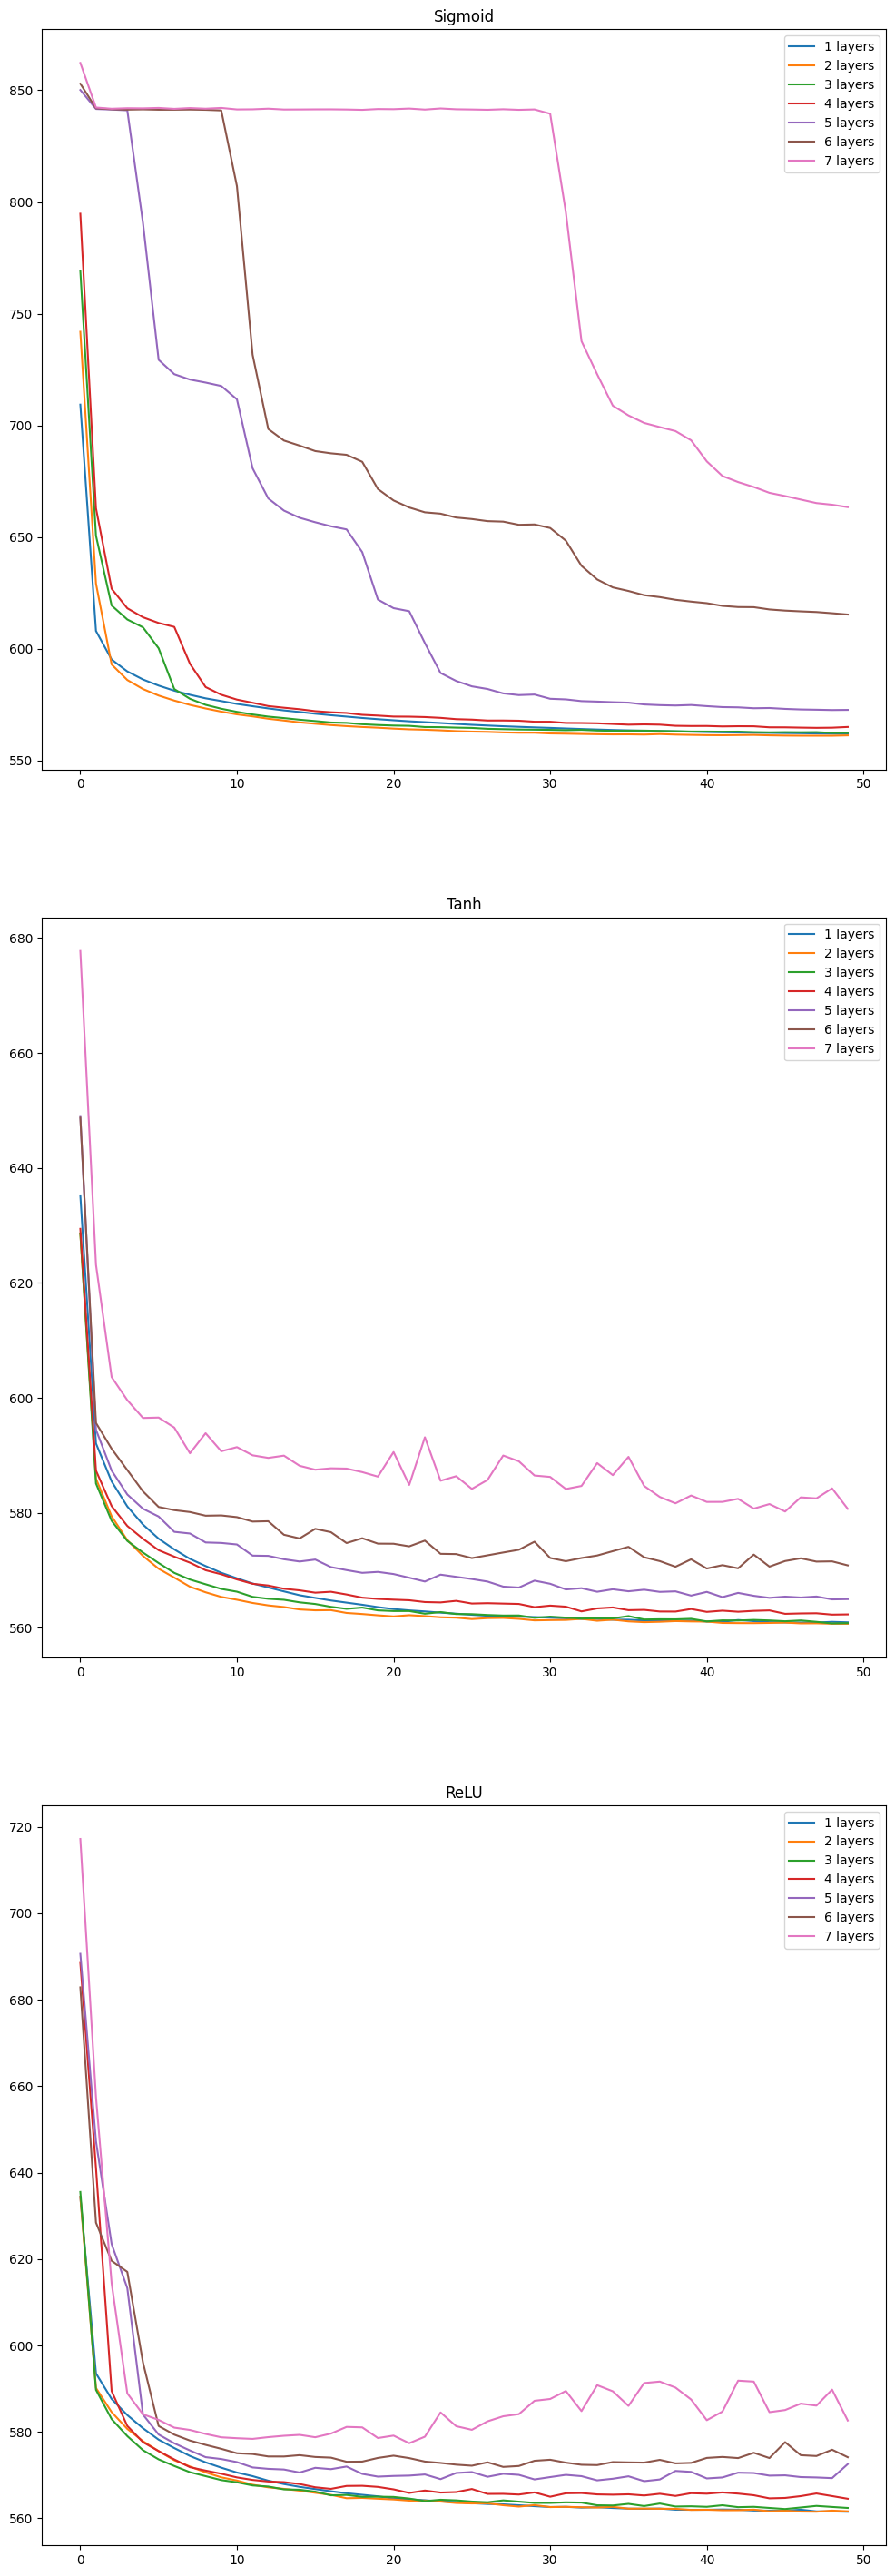

In [10]:
fig = plt.figure(figsize=(12, 12*len(ACTIVATIONS)))
axes = fig.subplots(len(ACTIVATIONS), 1)

for i in range(len(ACTIVATIONS)):
    relevant_results = [result for result in results_accumulator if result['fn'] == ACTIVATIONS[i].__name__]
    for result in relevant_results:
        axes[i].plot(result['losses'], label=f"{result['layers']} layers")
    axes[i].title.set_text(f"{ACTIVATIONS[i].__name__}")
    axes[i].legend()
    